#  Twitter Sentiment Analysis using RNN+Word2vec Embedding.ipynb

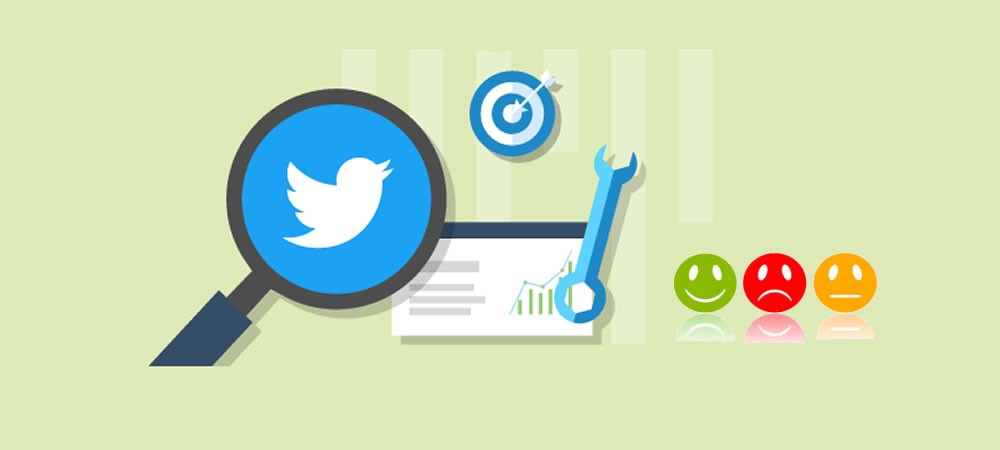

In [1]:
!pip install spacy
!python -m spacy download en_core_web_lg

     |████████████████████████████████| 827.9MB 1.2MB/s 
  Created wheel for en-core-web-lg: filename=en_core_web_lg-2.2.5-cp37-none-any.whl size=829180945 sha256=c81534b7508ed4862e2368f5db0d5f17875d7f58abac9fb3a16cc1ac219fd521
  Stored in directory: /tmp/pip-ephem-wheel-cache-fz3bl_cc/wheels/2a/c1/a6/fc7a877b1efca9bc6a089d6f506f16d3868408f9ff89f8dbfc
Successfully built en-core-web-lg
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [52]:
import spacy
import en_core_web_lg
import re
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split


from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,SimpleRNN
from keras import optimizers
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D,GlobalMaxPooling1D
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam


In [3]:
nlp = en_core_web_lg.load()

In [4]:
def get_wordcounts(x):
	length = len(str(x).split())
	return length

In [5]:
def get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

In [6]:
def get_avg_wordlength(x):
	count = get_charcounts(x)/get_wordcounts(x)
	return count

In [7]:
def get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

In [8]:
def get_hashtag_counts(x):
	l = len([t for t in x.split() if t.startswith('#')])
	return l

In [9]:
def get_mentions_counts(x):
	l = len([t for t in x.split() if t.startswith('@')])
	return l

In [10]:

def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

In [11]:
def get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

In [12]:
def get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

In [13]:
def get_emails(x):
	emails = re.findall(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+\b)', x)
	counts = len(emails)

	return counts, emails

In [14]:
def remove_emails(x):
	return re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", x)

In [15]:
def get_urls(x):
	urls = re.findall(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', x)
	counts = len(urls)

	return counts, urls

In [16]:
def remove_urls(x):
	return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

In [17]:
def remove_rt(x):
	return re.sub(r'\brt\b', '', x).strip()

In [18]:
def remove_special_chars(x):
	x = re.sub(r'[^\w ]+', "", x)
	x = ' '.join(x.split())
	return x

In [19]:
def remove_html_tags(x):
	return BeautifulSoup(x, 'lxml').get_text().strip()

In [20]:
def remove_accented_chars(x):
	x = unicodedata.normalize('NFKD', x).encode('ascii', 'ignore').decode('utf-8', 'ignore')
	return x

In [21]:
def remove_stopwords(x):
	return ' '.join([t for t in x.split() if t not in stopwords])	

In [22]:
def make_base(x):
	x = str(x)
	x_list = []
	doc = nlp(x)
	
	for token in doc:
		lemma = token.lemma_
		if lemma == '-PRON-' or lemma == 'be':
			lemma = token.text

		x_list.append(lemma)
	return ' '.join(x_list)

In [23]:
def get_value_counts(df, col):
	text = ' '.join(df[col])
	text = text.split()
	freq = pd.Series(text).value_counts()
	return freq

In [24]:
def remove_common_words(x, freq, n=20):
	fn = freq[:n]
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

In [25]:
def remove_rarewords(x, freq, n=20):
	fn = freq.tail(n)
	x = ' '.join([t for t in x.split() if t not in fn])
	return x

In [26]:
def remove_dups_char(x):
	x = re.sub("(.)\\1{2,}", "\\1", x)
	return x

In [27]:
def spelling_correction(x):
	x = TextBlob(x).correct()
	return x

In [28]:
def get_basic_features(df):
	if type(df) == pd.core.frame.DataFrame:
		df['char_counts'] = df['text'].apply(lambda x:get_charcounts(x))
		df['word_counts'] = df['text'].apply(lambda x:get_wordcounts(x))
		df['avg_wordlength'] = df['text'].apply(lambda x:get_avg_wordlength(x))
		df['stopwords_counts'] = df['text'].apply(lambda x:get_stopwords_counts(x))
		df['hashtag_counts'] = df['text'].apply(lambda x:get_hashtag_counts(x))
		df['mentions_counts'] = df['text'].apply(lambda x:get_mentions_counts(x))
		df['digits_counts'] = df['text'].apply(lambda x:get_digit_counts(x))
		df['uppercase_counts'] = df['text'].apply(lambda x:get_uppercase_counts(x))
	else:
		print('ERROR: This function takes only Pandas DataFrame')

In [30]:
df = pd.read_csv('/content/twitter4000.csv')

In [31]:
df.head()

,twitts,sentiment
0,is bored and wants to watch a movie any sugge...,0
1,back in miami. waiting to unboard ship,0
2,"@misskpey awwww dnt dis brng bak memoriessss, ...",0
3,ughhh i am so tired blahhhhhhhhh,0
4,@mandagoforth me bad! It's funny though. Zacha...,0


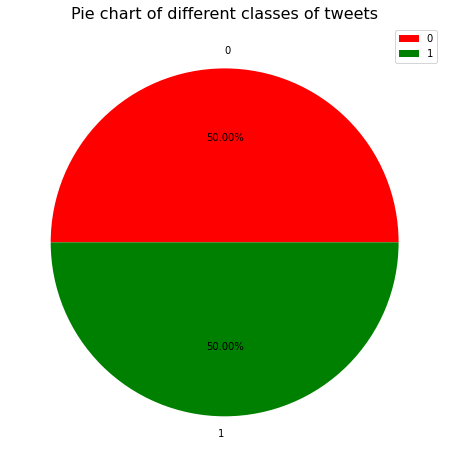

In [32]:
fig = plt.figure(figsize=(8,8))
targets = df.groupby('sentiment').size()
targets.plot(kind='pie', subplots=True, figsize=(10, 8), autopct = "%.2f%%", colors=['red','green','blue'])
plt.title("Pie chart of different classes of tweets",fontsize=16)
plt.ylabel("")
plt.legend()
plt.show()

In [33]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [ ]:
# dimensionality of the data
df.shape

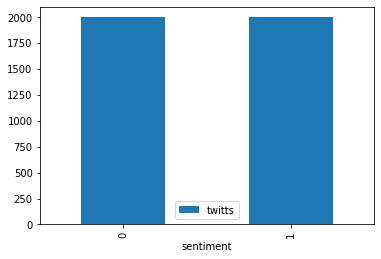

In [35]:
# The distribution of sentiments
df.groupby('sentiment').count().plot(kind='bar')

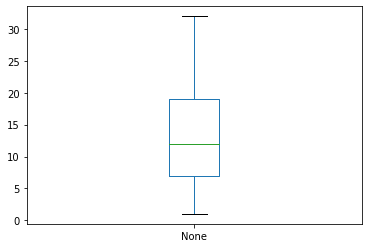

In [36]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['twitts']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

In [37]:
y = df['sentiment']

In [38]:
text=df["twitts"].tolist()

## Tokenization

In [39]:
# use the Tokenizer class : create a word-to-index dictionary. In the word-to-index dictionary
token=Tokenizer()
token.fit_on_texts(text)

In [40]:
token

## unique words

In [41]:
# Adding 1 because of reserved 0 index
vocab_size=len(token.word_index)+1
vocab_size

10135

In [42]:
encoded_text=token.texts_to_sequences(text)
print(encoded_text)

[[8, 304, 6, 345, 2, 191, 4, 236, 254, 3079], [52, 10, 1019, 206, 2, 3080, 3081], [3082, 1197, 668, 1955, 3083, 1956, 3084, 1, 3085, 17, 115, 44], [1957, 1, 62, 15, 192, 3086], [3087, 13, 113, 47, 328, 136, 3088, 3089, 8, 101, 88, 11, 4, 285, 136, 48, 2, 448, 21, 277, 3, 3090, 218, 3, 449], [3091, 17, 15, 315, 19, 3, 892, 164, 5, 1459, 14, 3092, 3093, 386, 8, 66, 1460], [3094, 110, 366, 20, 1, 66, 85, 2, 108, 1, 117, 38, 536, 44, 182, 108, 78, 346, 207, 305, 17, 3095], [450, 73, 537, 569, 295, 1, 316, 2, 77, 3096, 367, 3097, 1461, 24, 187, 893], [3098, 21, 1958, 304, 19, 45, 44], [409, 3099, 3100], [3101, 132, 609, 79, 3, 193, 368, 17, 131, 3, 158, 199], [3102, 127, 1, 139, 226, 2, 1020, 9, 29, 1, 222, 74, 55, 2, 3103, 16, 3104], [67, 894, 423], [1959, 119, 52, 56, 211, 159, 387, 669, 48, 68, 255, 1462, 3, 3105, 71, 570, 5, 1959, 329], [1960, 3106, 3107, 46, 3108, 3109], [3110, 1463, 70, 19, 227, 17, 28, 2], [3111, 1, 245, 212, 1961, 51, 72, 36, 146, 246, 3112, 1, 538, 20, 74, 507, 196

In [45]:
max_lenth=120 #set the maximum size of each list to 120.
X=pad_sequences(encoded_text,maxlen=max_lenth,padding='post')

In [46]:
print(X)

[[    8   304     6 ...     0     0     0]
 [   52    10  1019 ...     0     0     0]
 [ 3082  1197   668 ...     0     0     0]
 ...
 [ 1033    21  1021 ...     0     0     0]
 [10134   134     7 ...     0     0     0]
 [   94    11   226 ...     0     0     0]]


In [47]:
X.shape

(4000, 120)

In [49]:
# train test split 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42,stratify = y)

In [50]:
print("shape of X_train: ",X_train.shape)
print("shape of X_test: ",X_test.shape)

print("shape of y_train: ",y_train.shape)
print("shape of y_test: ",y_test.shape)

shape of X_train:  (3200, 120)
shape of X_test:  (800, 120)
shape of y_train:  (3200,)
shape of y_test:  (800,)


In [54]:
vec_size=300
model=Sequential()
model.add(Embedding(vocab_size,vec_size,input_length=120,))
model.add(SimpleRNN(50,return_sequences = False))
model.add(Dense(1,activation='sigmoid'))
model.summary()
    
adam = optimizers.Adam(lr = 0.001)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 300)          3040500   
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 50)                17550     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 3,058,101
Trainable params: 3,058,101
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [56]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [58]:
%%time
history=model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=20)

Epoch 1/20
100/100 [==============================] - 6s 63ms/step - loss: 0.4543 - accuracy: 0.8150 - val_loss: 0.9174 - val_accuracy: 0.5213
Epoch 2/20
100/100 [==============================] - 6s 63ms/step - loss: 0.3144 - accuracy: 0.8856 - val_loss: 1.0244 - val_accuracy: 0.5462
Epoch 3/20
100/100 [==============================] - 6s 64ms/step - loss: 0.2511 - accuracy: 0.9237 - val_loss: 1.2417 - val_accuracy: 0.5350
Epoch 4/20
100/100 [==============================] - 6s 63ms/step - loss: 0.1953 - accuracy: 0.9397 - val_loss: 1.3266 - val_accuracy: 0.5250
Epoch 5/20
100/100 [==============================] - 6s 64ms/step - loss: 0.1485 - accuracy: 0.9600 - val_loss: 1.4514 - val_accuracy: 0.5362
Epoch 6/20
100/100 [==============================] - 6s 64ms/step - loss: 0.1351 - accuracy: 0.9647 - val_loss: 1.5895 - val_accuracy: 0.5437
Epoch 7/20
100/100 [==============================] - 6s 63ms/step - loss: 0.1151 - accuracy: 0.9716 - val_loss: 1.6105 - val_accuracy: 0.5362

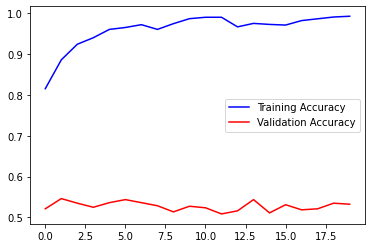

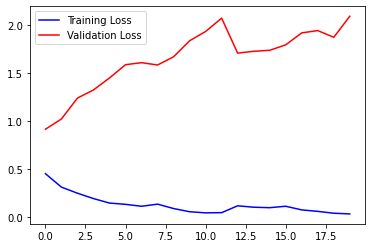

In [60]:
%matplotlib inline
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(20) #No. of epochs

#Plot training and validation accuracy per epoch
import matplotlib.pyplot as plt
plt.plot(epochs,acc,'b',label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.legend()
plt.figure()

#Plot training and validation loss per epoch
plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.legend()
plt.show()